# PRÁCTICA 4: DIFERENCIA TEMPORAL CON OPENAI GYM Y PYTHON

En esta cuarta y última práctica del curso veremos cómo entrenar un agente capaz de moverse en un pequeño tablero que emula un Taxi que debe recoger a un pasajero y dejarlo en otro punto del tablero.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mostrar_estado(env, S):
    '''Imprime en pantalla el estado actual (ubicación del taxi,
    destino y origen)

    Parámetros:
    - env: el entorno de OpenAI Gym
    - S: el estado actual codificado
    '''

    # Decodificar el estado
    tx_fil, tx_col, origen, destino = env.env.decode(S)

    # Diccionarios
    origenes = {0: 'R(ed)', 1: 'G(reen)', 2: 'Y(ellow)', 3: 'B(lue)', 4:'In taxi'}
    destinos = {0: 'R(ed)', 1: 'G(reen)', 2: 'Y(ellow)', 3: 'B(lue)'}

    # Imprimir información en pantalla
    print(f'Ubicación del taxi (fil, col): {tx_fil+1, tx_col+1}')
    print(f'Origen: {origenes[origen]}')
    print(f'Destino: {destinos[destino]}')

# -----------------------------------------------------
def inicializar_Q(nS, nA, tipo='ones'):
    '''
    Inicializar la función Q(S,A) a valores iguales a 1.

    Parámetros:
    - nS: número de estados
    - nA: número de acciones

    Retorna la matriz Q(S,A)
    '''
    if tipo == 'ones':
    	Q = np.ones((nS,nA))
    elif tipo == 'random':
    	Q = np.random.rand(nS,nA)

    return Q

# -----------------------------------------------------
def e_greedy(s, Q, e, nA):
    '''
    Para un estado "s" selecciona una acción proveniente de Q(S,A) usando el enfoque e-greedy

    Parámetros:
    - s: el estado para el cual se desea obtener la acción
    - Q(S,A): tabla Q con S estados y A acciones
    - e: valor de épsilon (entre 0 y 1)
    - nA: número de acciones

    Retorna la acción seleccionada
    '''

    if np.random.rand() >= e:
        # Tomar la mejor acción con una probabilidad 1-e
        accion = np.argmax(Q[s, :])
    else:
        # Tomar cualquier acción aleatoriamente (con probabilidad e)
        accion = np.random.randint(0, nA)

    return accion

# -----------------------------------------------------
def sarsa(env, alpha, gamma, epsilon, nS, nA, K, verbose=False):
    '''
    Algoritmo de control SARSA

    Parámetros:
    - env: el entorno
    - alpha: la tasa de aprendizaje (entre 0 y 1)
    - gamma: factor de descuento (entre 0 y 1)
    - epsilon: parámetro para el algoritmo e-greedy (entre 0 y 1)
    - nS, nA: número de estados y de acciones
    - K: número de episodios a generar
    - verbose: imprimir en pantalla el progreso del entrenamiento (por defecto falso)
    '''

    # Inicializar Q(S,A) y almacenar retorno (la evolucion del entrenamiento)
    Q = inicializar_Q(nS, nA)
    retorno = []

    # Correr K episodios de interacción y estimar Q(S,A)
    for episodio in range(K):
        # Inicializar retorno acumulado
        retorno_acumulado = 0

        # Ir al primer estado del episodio
        s = env.reset()

        # Elegir acción usando e-greedy
        a = e_greedy(s, Q, epsilon, nA)

        done = False # Aún no estamos en un estado terminal

        while not done:
            # Iniciar interacciones y actualizar función Q
            s_, r_, done, info = env.step(a)
            a_ = e_greedy(s_, Q, epsilon, nA)
            retorno_acumulado += r_

            if not done:
                # Actualizar Q si no es un episodio terminal
                Q[s, a] += alpha * ( r_ + (gamma * Q[s_, a_] ) - Q[s, a] )
            else:
                # Si el episodio es terminal no se añade gamma * Q[S_, a_]
                # (porque Q[s_, a_] = 0 por ser estado terminal)
                Q[s, a] += alpha * ( r_ - Q[s, a] )
                retorno.append(retorno_acumulado)

            # Actualizar el estado y la acción
            s, a = s_, a_

            # Imprimir información cada 100 episodios
            if verbose:
                if episodio%100 == 0:
                    print(f'Episodio: {episodio+1}/{K}:')
                    print(f'\t\tRecompensa: {r_}')


    # Al finalizar tendremos la tabla Q, que implícitamente
    # contendrá la política
    return Q, retorno

# -----------------------------------------------------
def qlearning(env, alpha, gamma, epsilon, nS, nA, K, verbose=False):
    '''
    Algoritmo de control Q-learning

    Parámetros:
    - env: el entorno
    - alpha: la tasa de aprendizaje (entre 0 y 1)
    - gamma: factor de descuento (entre 0 y 1)
    - epsilon: parámetro para el algoritmo e-greedy
    - nS, nA: número de estados y de acciones
    - K: número de episodios a generar
    - verbose: imprimir en pantalla el progreso del entrenamiento (por defecto falso)
    '''

    # Inicializar Q(S,A) y almacenar retorno (la evolución del entrenamiento)
    Q = inicializar_Q(nS, nA)
    retorno = []

    # Correr K episodios de interacción y estimar Q(S,A)
    for episodio in range(K):
        # Inicializar retorno total
        retorno_acumulado = 0

        # Ir al primer estado del episodio
        s = env.reset()

        # Elegir acción usando e-greedy
        a = e_greedy(s, Q, epsilon, nA)

        done = False # Aún no estamos en un estado terminal

        while not done:
            # Iniciar interacciones y actualizar función Q
            s_, r_, done, info = env.step(a)
            a_ = np.argmax(Q[s_, :]) # <---- ESTA ES LA DIFERENCIA CON SARSA
            retorno_acumulado += r_

            if not done:
                # Si no es un episodio terminal, actualizar Q
                Q[s, a] += alpha * ( r_ + (gamma * Q[s_, a_] ) - Q[s, a] )
            else:
                # Si el episodio es terminal no se añade gamma * Q[S_, a_]
                # (porque Q[s_, a_] = 0 por ser estado terminal)
                Q[s, a] += alpha * ( r_ - Q[s, a] )
                retorno.append(retorno_acumulado)

            # Actualizar el estado y la acción
            s, a = s_, a_

            # Imprimir información cada 100 episodios
            if verbose:
                if episodio%100 == 0:
                    print(f'Episodio: {episodio+1}/{K}:')
                    print(f'\t\tRecompensa final: {r_}')


    # Al finalizar tendremos la tabla Q, que implícitamente
    # contendrá la política
    return Q, retorno

# -----------------------------------------------------
def interaccion(env, Q, method=None):
    it = 0
    s = env.reset()

    print('Resultado de la interacción:')
    print('-'*60)
    print('-'*60)

    # Imprimir estado y entorno iniciales
    print('**** Entorno-agente al inicio: ****')
    env.render()
    _, _, _, dest_i = env.env.decode(s)
    mostrar_estado(env, s)

    print('\nInteractuando...\n')

    # Hacer que el agente interactúe con el entorno tomando como política
    # el máximo de la función Q para cada estado
    a = np.argmax(Q[s,:]) # ¡La política!
    done = False

    # Interactuar hasta llegar a un estado terminal
    while not done:
        it += 1
        # Iniciar interacciones y actualizar función Q
        s, r, done, info = env.step(a)
        a = np.argmax(Q[s, :])

    # Imprimir información final
    _, _, _, dest_f = env.env.decode(s)
    if dest_i == dest_f:
        print(f'\nEl episodio culminó ***EXITOSAMENTE*** en {it} iteraciones')
    else:
        print(f'\nEl episodio culminó en {it} iteraciones')

    print('**** Entorno-agente al final: ****')
    env.render()
    mostrar_estado(env, s)
    print(f'Recompensa obtenida: {r}')

# -----------------------------------------------------
def graficar_entrenamiento(retornos, titulos):

    # Generar figura
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6),
    	sharex=True, sharey=True)

    # Graficar
    ax1.plot(retornos[0])
    ax1.title.set_text(titulos[0])
    ax2.plot(retornos[1], 'tab:orange')
    ax2.title.set_text(titulos[1])
    ax3.plot(retornos[2], 'tab:green')
    ax3.title.set_text(titulos[2])
    ax4.plot(retornos[3], 'tab:red')
    ax4.title.set_text(titulos[3])

    # Etiquetar ejes
    plt.setp([ax3, ax4], xlabel='Iteración')
    plt.setp([ax1, ax3], ylabel='Retorno')


## 1. El juego del taxi

Aunque el objetivo final del Aprendizaje por Refuerzo no es simplemente entrenar agentes para que "aprendan" a jugar, el uso de juegos es una herramienta muy útil para entender los elementos básicos de los diferentes algoritmos de entrenamiento.

Así, como en prácticas anteriores, pondremos a prueba lo aprendido hasta el momento para resolver un pequeño juego.

Este juego ha sido tomado del ejemplo propuesto por Dietterich (2008) en su artículo [Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition](https://arxiv.org/pdf/cs/9905014.pdf) y que corresponde a un entorno ya implementado en OpenAI Gym.

### 1.1. Objetivo del juego y características del entorno

El taxi (agente) debe ir a la ubicación del pasajero ("origen"), recogerlo y dejarlo en el "destino". El episodio culmina cuando el taxi deja al pasajero en este "destino".

![](https://drive.google.com/uc?export=view&id=1TwKEwQ4bNiHIk_6E4Kg2HnZi4N4XlPci)

En total se tendrán 500 posibles estados: 25 casillas x 5 posibles ubicaciones del pasajero (R, G, Y, B o dentro del taxi) x 4 posibles destinos (R, G, Y o B)

### 1.2. Objetivo de la práctica

Entrenar al agente (encontrar la política) de forma tal que se obtenga el máximo retorno posible en cada episodio.

## 2. El entorno en OpenAI Gym

In [ ]:
# Se requiere la versión 0.23.1 de OpenAI Gym para poder
# usar el método "render". Versiones más recientes no
# funcionan con Google Colab
!pip install gym==0.23.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701367 sha256=9dc7512869edd39c2d8ec361c0ebfafa80a74c44f4e0d349136048abba6340b4
  Stored in directory: /root/.cache/pip/wheels/1a/00/fb/fe5cf2860fb9b7bc860e28f00095a1f42c7b726dd6f42d1acc
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [ ]:
import gym

In [ ]:
# Crear el entorno y visualizar sus características
env = gym.make("Taxi-v3")
S = env.reset()
env.render()

print('Estado inicial: {}'.format(S))
print('Número de estados: {}'.format(env.observation_space.n))
print('Número de acciones: {}'.format(env.action_space.n))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Estado inicial: 141
Número de estados: 500
Número de acciones: 6


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [ ]:
# El estado se encuentra codificado, así que usaremos
# la función "mostrar_estado" para decodificarlo e
# imprimir la información en pantalla
mostrar_estado(env, S)

Ubicación del taxi (fil, col): (2, 3)
Origen: R(ed)
Destino: G(reen)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Interacción
acciones = {0: 'abajo', 1: 'arriba', 2: 'derecha',
            3: 'izquierda', 4: 'recoger', 5: 'dejar'}

A = env.action_space.sample()
S, R, done, info = env.step(A)
env.render()

print(f'Acción seleccionada: {acciones[A]}')
mostrar_estado(env,S)
print(f'Recompensa obtenida: {R}')
print(f'¿Terminó el episodio?: {done}')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
Acción seleccionada: recoger
Ubicación del taxi (fil, col): (1, 5)
Origen: In taxi
Destino: G(reen)
Recompensa obtenida: -1
¿Terminó el episodio?: False


## 3. Funciones auxiliares

Usaremos inicialmente el algoritmo de control SARSA visto anteriormente.

Antes de ver la implementación, veamos dos funciones auxiliares:
- `inicializar_Q` que permite inicializar la tabla Q (función acción-valor)
- `e_greedy` que permite seleccionar una acción de la tabla Q usando un enfoque $\epsilon$-greedy

In [ ]:
# Prueba de la función "inicializar_Q"
Q = inicializar_Q(500,6, tipo='ones')
print(Q.shape)
print(Q)

Q = inicializar_Q(500,6, tipo='random')
print(Q.shape)
print(Q)

(500, 6)
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
(500, 6)
[[0.44171795 0.83066037 0.72640922 0.56973291 0.65955746 0.06893164]
 [0.03825339 0.70907011 0.14314052 0.39853058 0.70899515 0.56821743]
 [0.01486377 0.39380943 0.58651256 0.44972716 0.88673772 0.8473825 ]
 ...
 [0.24819426 0.42268567 0.53718647 0.17332229 0.63524483 0.31362741]
 [0.19669335 0.28040236 0.11676812 0.33000716 0.23484318 0.99074602]
 [0.61637931 0.83690215 0.6875312  0.62283187 0.60833461 0.51234893]]


Realmente no interesa el tipo de inicialización a usar, pues tarde o temprano tanto SARSA como Q-learning llegarán a la función Q (y política) óptima.

Pero con el propósito de comparar los dos algoritmos haremos uso de la inicialización tipo `ones`.

Veamos ahora la función `e_greedy`:

In [ ]:
# Prueba para el estado s=5
s = 5
e = 0.2 # La mejor acción tendrá una prob. de 1-e de ser seleccionada
a = e_greedy(s,Q,e,3)
print(f'Tabla Q para s={s}: {Q[s,:]}')
print(f'Acción seleccionada para e={e}: {a}')

Tabla Q para s=5: [0.75930102 0.62858343 0.75256612]
Acción seleccionada para e=0.2: 2


## 4. Control con SARSA

Ahora sí entrenemos el agente con el algoritmo SARSA. Para ello usaremos la función `sarsa`, definiendo inicialmente los **hiperparámetros** sin un criterio en particular:

In [ ]:
# Hiperparámetros
ALPHA = 0.4
GAMMA = 0.999
EPSILON = 0.1 # (Probabilidad de escoger mejor acción = 1-0.1 = 0.9)
K = 2000

# Número de estados/acciones
NS = env.observation_space.n
NA = env.action_space.n

Q_s, ret_s = sarsa(env, ALPHA, GAMMA, EPSILON, NS, NA, K,True)

Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -10
Episodio: 1/2000:
		Recompensa: -10
Episodio: 1/2000:
		Recompensa: -10
Episodio: 1/2000:
		Recompensa: -10
Episodio: 1/2000:
		Recompensa: -10
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -1
Episodio: 1/2000:
		Recompensa: -10
Episodio: 1/2000:
		Recompensa: -10
Episodio: 1/2

Veamos cuál ha sido el progreso del entrenamiento. La idea es que al comienzo el retorno obtenido (`ret_s`) debe ser bajo (valores negativos) y a medida que progresa este valor debería ser más alto (es decir cercano a cero):

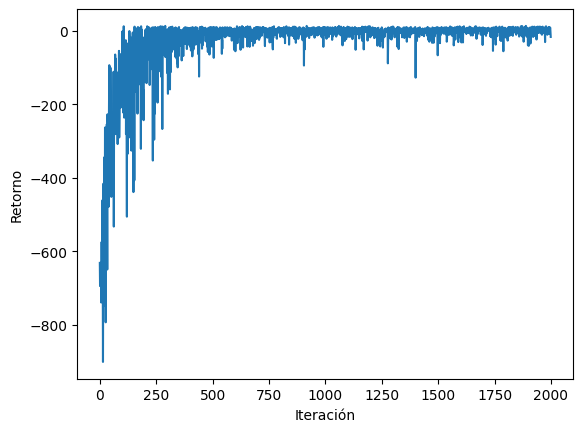

In [ ]:
plt.plot(ret_s)
plt.xlabel('Iteración');
plt.ylabel('Retorno');

En efecto tenemos el comportamiento esperado.

Pero ¿será que podemos mejorar este desempeño? La respuesta es sí, y para esto debemos realizar un **ajuste de los hiperparámetros**.

### 4.1. Ajuste de hiperparámetros

Este ajuste se debe hacer de forma sistemática, es decir modificando sólo uno de ellos, dejando los demás fijos, y observando si mejora/empeora el entrenamiento

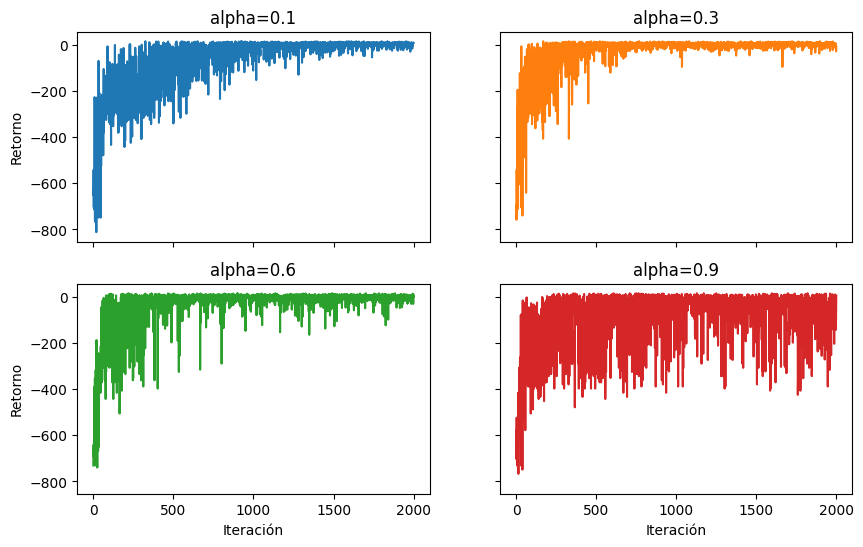

In [ ]:
# Entrenamiento con diferentes tasas de aprendizaje (ALPHA)
Q_s1, ret_s1 = sarsa(env, 0.1, GAMMA, EPSILON, NS, NA, K)
Q_s2, ret_s2 = sarsa(env, 0.3, GAMMA, EPSILON, NS, NA, K)
Q_s3, ret_s3 = sarsa(env, 0.6, GAMMA, EPSILON, NS, NA, K)
Q_s4, ret_s4 = sarsa(env, 0.9, GAMMA, EPSILON, NS, NA, K)

# Curvas de entrenamiento resultantes
retornos = [ret_s1, ret_s2, ret_s3, ret_s4]
titulos = ['alpha=0.1', 'alpha=0.3', 'alpha=0.6', 'alpha=0.9']
graficar_entrenamiento(retornos, titulos)

Al parecer un `ALPHA=0.3` resulta adecuado, porque con menos iteraciones logra estabilizarse (llegar casi a cero) más rápido el retorno obtenido.

Dejaremos fijo este hiperparámetro y nos enfocaremos ahora en `K`
 (el número de episodios usados en el entrenamiento):

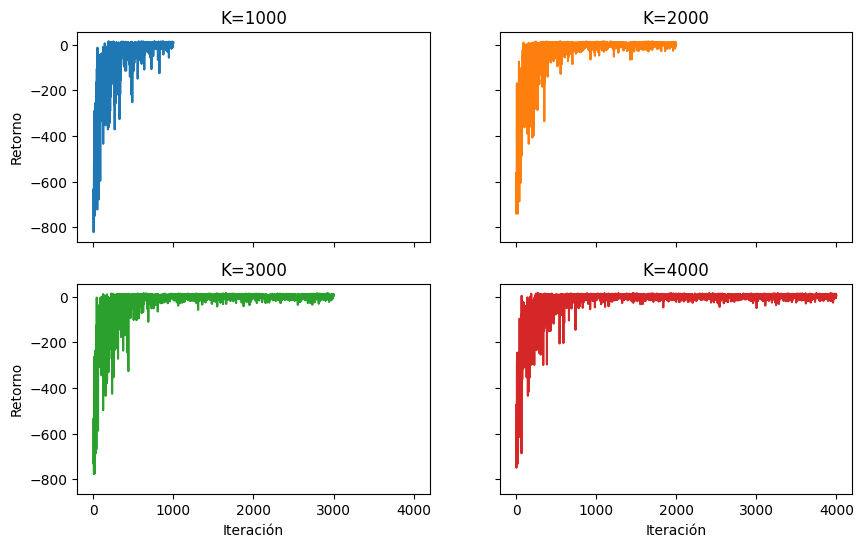

In [ ]:
# Entrenamiento con diferentes Ks
ALPHA = 0.3
Q_s1, ret_s1 = sarsa(env, ALPHA, GAMMA, EPSILON, NS, NA, 1000)
Q_s2, ret_s2 = sarsa(env, ALPHA, GAMMA, EPSILON, NS, NA, 2000)
Q_s3, ret_s3 = sarsa(env, ALPHA, GAMMA, EPSILON, NS, NA, 3000)
Q_s4, ret_s4 = sarsa(env, ALPHA, GAMMA, EPSILON, NS, NA, 4000)

# Curvas de entrenamiento resultantes
retornos = [ret_s1, ret_s2, ret_s3, ret_s4]
titulos = ['K=1000', 'K=2000', 'K=3000', 'K=4000']
graficar_entrenamiento(retornos, titulos)

No parece haber mucha diferencia entre uno y otro valor. Dado que el entrenamiento es relativamente rápido, usaremos K = 4000.

Ahora ajustaremos el hiperparámetro $\epsilon$:

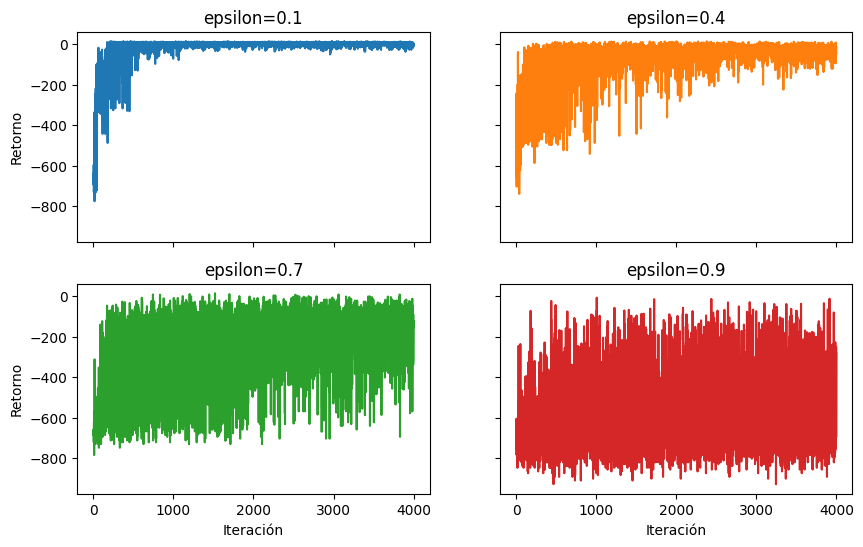

In [ ]:
K = 4000

# Entrenamiento con diferentes epsilon
Q_s1, ret_s1 = sarsa(env, ALPHA, GAMMA, 0.1, NS, NA, K)
Q_s2, ret_s2 = sarsa(env, ALPHA, GAMMA, 0.4, NS, NA, K)
Q_s3, ret_s3 = sarsa(env, ALPHA, GAMMA, 0.7, NS, NA, K)
Q_s4, ret_s4 = sarsa(env, ALPHA, GAMMA, 0.9, NS, NA, K)

# Curvas de entrenamiento resultantes
retornos = [ret_s1, ret_s2, ret_s3, ret_s4]
titulos = ['epsilon=0.1', 'epsilon=0.4', 'epsilon=0.7', 'epsilon=0.9']
graficar_entrenamiento(retornos, titulos)

El resultado anterior tiene lógica, pues entre mayor sea $\epsilon$ mayor importancia estaremos dando a la exploración (es decir a acciones seleccionadas aleatoriamente) y menor a la explotación.

Así que ajustaremos $\epsilon$ en 0.1 y nos enfocaremos en el último hiperparámetro: $\gamma$ (el factor de descuento):

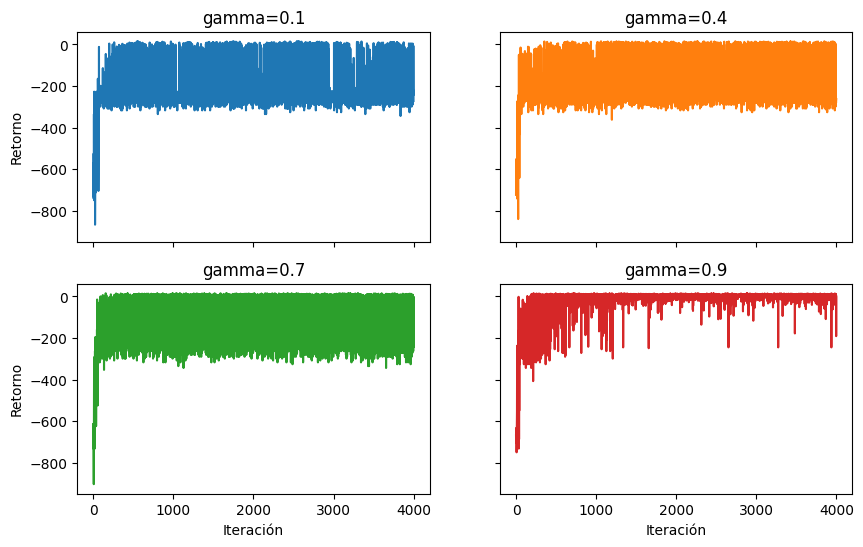

In [ ]:
EPSILON = 0.1

# Entrenamiento con diferentes gamma
Q_s1, ret_s1 = sarsa(env, ALPHA, 0.1, EPSILON, NS, NA, K)
Q_s2, ret_s2 = sarsa(env, ALPHA, 0.4, EPSILON, NS, NA, K)
Q_s3, ret_s3 = sarsa(env, ALPHA, 0.7, EPSILON, NS, NA, K)
Q_s4, ret_s4 = sarsa(env, ALPHA, 0.9, EPSILON, NS, NA, K)

# Curvas de entrenamiento resultantes
retornos = [ret_s1, ret_s2, ret_s3, ret_s4]
titulos = ['gamma=0.1', 'gamma=0.4', 'gamma=0.7', 'gamma=0.9']
graficar_entrenamiento(retornos, titulos)

Observamos que entre más alto sea el valor de $\gamma$ más importancia le daremos al comportamiento futuro y menos a la acción presente y por tanto mejorará la interacción.

Así que usaremos un $\gamma$ lo más cercano posible a 1 (0.999) y entrenaremos el agente con los hiperparámetros ajustados:

- ALPHA = 0.3
- GAMMA = 0.999
- EPSILON = 0.1
- K = 4000

In [ ]:
GAMMA = 0.999

Q_s, ret_s = sarsa(env, ALPHA, GAMMA, EPSILON, NS, NA, K)

¡Perfecto! Ya tenemos nuestro agente entrenado.

Al final de la práctica veremos cómo usar la tabla Q obtenida para generar interacciones. Pero antes veamos cómo realizar el entrenamiento con el algoritmo Q-learning.

## 5. Control con Q-learning

Seguiremos la misma lógica usada para el control con SARSA para llevar a cabo el entrenamiento de nuestro agente usando el algoritmo Q-learning.

En este caso usaremos la funcion `q_learning` que implementa este algoritmo:

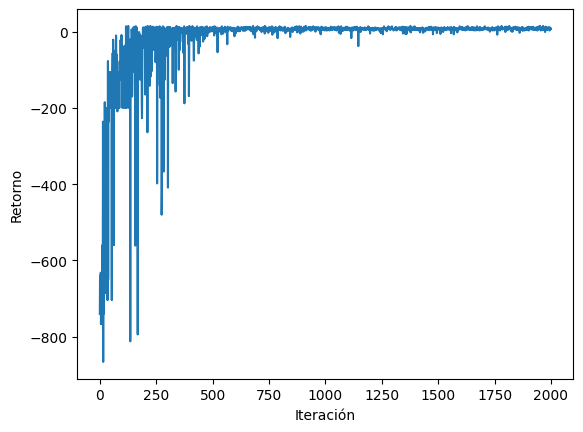

In [ ]:
# Prueba del algoritmo Q-learning usando un set arbitrario
# de hiperparámetros
ALPHA = 0.4
GAMMA = 0.999
EPSILON = 0.1 # (Probabilidad de escoger mejor acción = 1-0.1 = 0.9)
NS = env.observation_space.n
NA = env.action_space.n
K = 2000

Q_ql, ret_ql = qlearning(env, ALPHA, GAMMA, EPSILON, NS, NA, K)

# Y grafiquemos la curva de entrenamiento
plt.plot(ret_ql)
plt.xlabel('Iteración');
plt.ylabel('Retorno');

De nuevo, al igual que con SARSA, en este caso debemos hacer un ajuste de hiperparámetros.

Así que, si seguimos el mismo procedimiento de antes, llegaremos a este set:

- ALPHA = 0.6
- GAMMA = 0.999
- EPSILON = 0.1
- K = 4000

Entrenemos nuestro agente con estos hiperparámetros:

In [ ]:
ALPHA = 0.6
GAMMA = 0.999
EPSILON = 0.1 # (Probabilidad de escoger mejor acción = 1-0.1 = 0.9)
K = 4000

Q_ql, ret_ql = qlearning(env, ALPHA, GAMMA, EPSILON, NS, NA, K)

Ahora sí, con el agente entrenado usando los dos métodos, intentemos ver cuál de ellos tiene el mejor desempeño.

Para ello podemos simplemente graficar las curvas de entrenamiento obtenidas en cada caso:

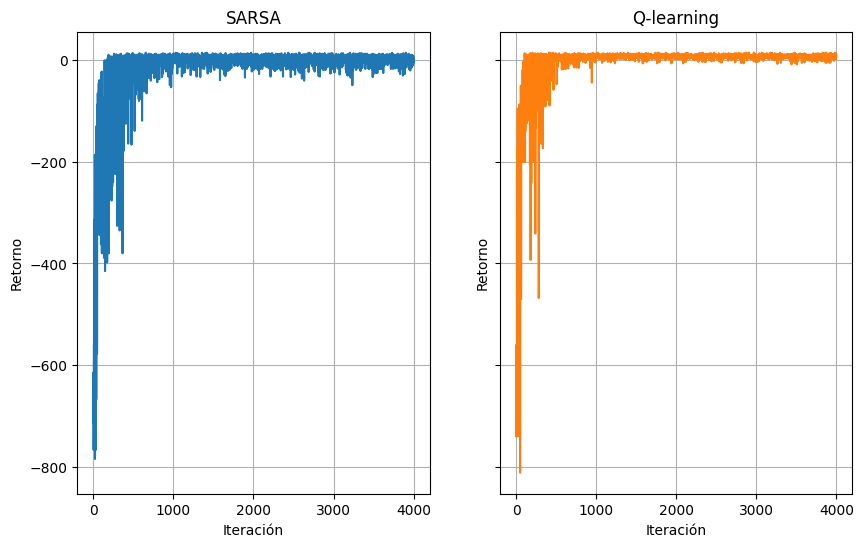

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Graficar
ax1.plot(ret_s)
ax1.title.set_text('SARSA')
ax1.set_xlabel('Iteración')
ax1.grid(True)

ax2.plot(ret_ql, 'tab:orange')
ax2.title.set_text('Q-learning')
ax2.set_xlabel('Iteración')
ax2.grid(True)

plt.setp([ax1, ax2], ylabel='Retorno');

Vemos que la convergencia de Q-learning es significativamente más rápida que SARSA: en la iteración 1.000 (aprox.) ya se estabiliza el primero y su retorno ya es positivo, mientras que para esa misma iteración SARSA aún no se estabiliza (de hecho en la iteración 4.000 su retorno sigue siendo negativo en ocasiones).

Esto confirma que Q-learning permite entrenar el agente de forma adecuada y con un menor número de iteraciones en comparación con SARSA.

¡Ya estamos listos ahora sí para hacer que el agente entrenado interactúe con el entorno!

## 6. Interacción



In [ ]:
#interaccion(env,Q_ql)
interaccion(env,Q_s)

Resultado de la interacción:
------------------------------------------------------------
------------------------------------------------------------
**** Entorno-agente al inicio: ****
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Ubicación del taxi (fil, col): (5, 2)
Origen: B(lue)
Destino: G(reen)

Interactuando...


El episodio culminó ***EXITOSAMENTE*** en 13 iteraciones
**** Entorno-agente al final: ****
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Ubicación del taxi (fil, col): (1, 5)
Origen: G(reen)
Destino: G(reen)
Recompensa obtenida: 20
